## EDA

In [1]:
import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import hparams
import numpy as np
from utils import create_dataset, train_model
from models import  AutoEncoder
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

2022-12-11 22:55:09.707358: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-11 22:55:09.867913: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-11 22:55:10.495323: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rifat/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda-11.7/lib64:
2022-12-11 22:55:10.495446: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Coul

In [2]:

root_dir=os.getcwd()
root_dir

'/home/rifat/Desktop/Radiograph-Age-Prediction'

In [3]:
#loading dataframes
train_df = pd.read_csv(root_dir+'/data/Bone Age Training Set/train.csv')
df_test = pd.read_excel(root_dir+'/data/Bone Age Test Set/test.xlsx')

#appending file extension to id column for both training and testing dataframes
train_df['id'] = train_df['id'].apply(lambda x: str(x)+'.png')
df_test['Case ID'] = df_test['Case ID'].apply(lambda x: str(x)+'.png') 


train_df['img_path'] = train_df['id'].apply(lambda x: 'data/Bone Age Training Set/boneage-training-dataset/'+str(x))
df_test['img_path'] = df_test['Case ID'].apply(lambda x: 'data/Bone Age Test Set/boneage-testing-dataset/'+str(x)) 

#train_df = train_df.head(200)

male      6833
female    5778
Name: gender, dtype: int64


<AxesSubplot:xlabel='gender', ylabel='count'>

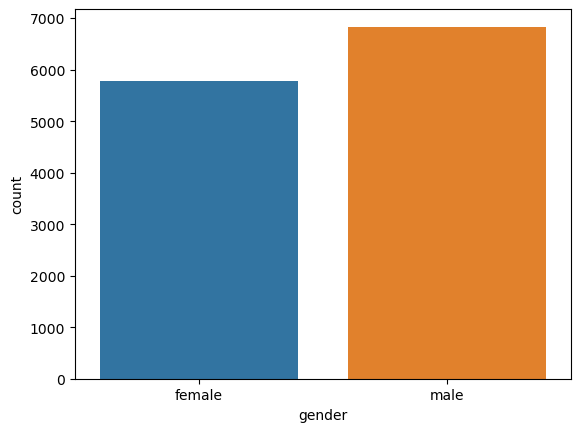

In [4]:
#finding out the number of male and female children in the dataset
#creating a new column called gender to keep the gender of the child as a string
train_df['gender'] = train_df['male'].apply(lambda x: 'male' if x else 'female')
print(train_df['gender'].value_counts())
sns.countplot(x = train_df['gender'])

In [5]:
#oldest child in the dataset
print('MAX age: ' + str(train_df['boneage'].max()) + ' months')

#youngest child in the dataset
print('MIN age: ' + str(train_df['boneage'].min()) + ' months')

#mean age is
mean_bone_age = train_df['boneage'].mean()
print('mean: ' + str(mean_bone_age))

#median bone age
print('median: ' +str(train_df['boneage'].median()))

#standard deviation of boneage
std_bone_age = train_df['boneage'].std()

#models perform better when features are normalised to have zero mean and unity standard deviation
#using z score for the training
train_df['bone_age_z'] = (train_df['boneage'] - mean_bone_age)/(std_bone_age)

print(train_df.head())

MAX age: 228 months
MIN age: 1 months
mean: 127.3207517246848
median: 132.0
         id  boneage   male  \
0  1377.png      180  False   
1  1378.png       12  False   
2  1379.png       94  False   
3  1380.png      120   True   
4  1381.png       82  False   

                                            img_path  gender  bone_age_z  
0  data/Bone Age Training Set/boneage-training-da...  female    1.279181  
1  data/Bone Age Training Set/boneage-training-da...  female   -2.800269  
2  data/Bone Age Training Set/boneage-training-da...  female   -0.809109  
3  data/Bone Age Training Set/boneage-training-da...    male   -0.177766  
4  data/Bone Age Training Set/boneage-training-da...  female   -1.100498  


Text(0.5, 1.0, 'Number of children in each age group')

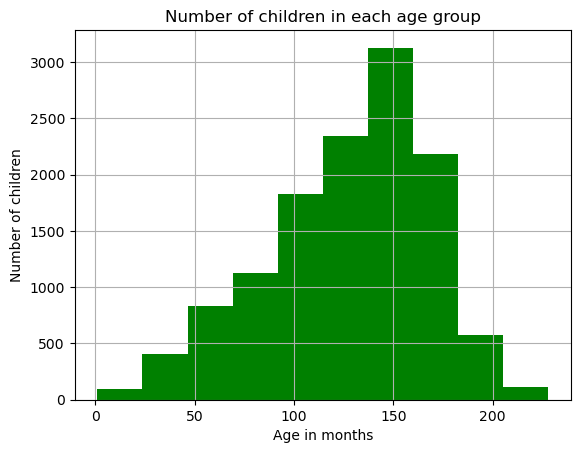

In [6]:
#plotting a histogram for bone ages
train_df['boneage'].hist(color = 'green')
plt.xlabel('Age in months')
plt.ylabel('Number of children')
plt.title('Number of children in each age group')

## Preprocess

In [7]:
x = train_df['img_path'].tolist()
y = train_df['boneage'].tolist()

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [9]:
train_dataset = create_dataset(x_train, y_train,
                               batch_size=hparams.BATCH_SIZE,
                               shuffle=True,
                               cache_file=hparams.TRAIN_CACHE_PATH)

val_dataset = create_dataset(x_val, y_val,
                              batch_size=hparams.BATCH_SIZE,
                              shuffle=False,
                              cache_file=hparams.VAL_CACHE_PATH)

train_steps = int(np.ceil(len(x_train) / hparams.BATCH_SIZE))
val_steps = int(np.ceil(len(x_val) / hparams.BATCH_SIZE))

2022-12-11 22:55:13.848524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 22:55:13.883643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 22:55:13.883812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 22:55:13.884488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
train_dataset.element_spec


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.float32, name=None))

In [11]:
from keras.metrics import mean_absolute_error
def mae_in_months(x_p, y_p):
    '''function to return mae in months'''
    return mean_absolute_error((std_bone_age*x_p + mean_bone_age), (std_bone_age*y_p + mean_bone_age)) 

In [12]:

model = AutoEncoder.auto_encoder()
model.compile(loss ='mse', optimizer= 'adam',metrics = ['mse'])
#model.compile(loss ='mse', optimizer= 'adam')
#model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       73856 

In [13]:

history = train_model(model, train_dataset, val_dataset,train_steps,val_steps)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rifat1493 (hda-project). Use `wandb login --relogin` to force relogin
wandb: ERROR Failed to sample metric: Not Supported


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/2


2022-12-11 22:55:23.030271: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-12-11 22:55:23.528047: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-11 22:55:23.586081: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


316/316 [==============================] - ETA: 0s - loss: 1889.3428 - mse: 1889.3428

INFO:tensorflow:Assets written to: /home/rifat/Desktop/Radiograph-Age-Prediction/wandb/run-20221211_225515-5512sklj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/rifat/Desktop/Radiograph-Age-Prediction/wandb/run-20221211_225515-5512sklj/files/model-best/assets
wandb: Adding directory to artifact (/home/rifat/Desktop/Radiograph-Age-Prediction/wandb/run-20221211_225515-5512sklj/files/model-best)... Done. 0.0s


316/316 [==============================] - 8s 19ms/step - loss: 1889.3428 - mse: 1889.3428 - val_loss: 465.3764 - val_mse: 465.3764 - lr: 0.0010
Epoch 2/2
313/316 [============================>.] - ETA: 0s - loss: 133.3712 - mse: 133.3712

INFO:tensorflow:Assets written to: /home/rifat/Desktop/Radiograph-Age-Prediction/wandb/run-20221211_225515-5512sklj/files/model-best/assets


INFO:tensorflow:Assets written to: /home/rifat/Desktop/Radiograph-Age-Prediction/wandb/run-20221211_225515-5512sklj/files/model-best/assets
wandb: Adding directory to artifact (/home/rifat/Desktop/Radiograph-Age-Prediction/wandb/run-20221211_225515-5512sklj/files/model-best)... Done. 0.0s


316/316 [==============================] - 6s 18ms/step - loss: 132.1944 - mse: 132.1944 - val_loss: 9.0545 - val_mse: 9.0545 - lr: 0.0010


## Checking GPU Status

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [15]:
import tensorflow as tf 

if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2022-12-11 22:55:36.133510: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 22:55:36.133762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 22:55:36.133887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 22:55:36.134071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 22:55:36.134189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [16]:
hparams.CONFIG

{'MODEL_NAME': 'baseline_encoder_model',
 'TRAIN_CACHE_PATH': 'data/artifact/cache/train_cache',
 'VAL_CACHE_PATH': 'data/artifact/cache/train_cache',
 'IMG_SIZE': 100,
 'LR': 0.0001,
 'BATCH_SIZE': 32,
 'EPOCHS': 2}